In [6]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torchvision as tv
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D

mnist_data = tv.datasets.MNIST(root=os.getcwd(),
                               download=True,
                               transform=tv.transforms.ToTensor())

kmnist_data = tv.datasets.KMNIST(root=os.getcwd(),
                                 download=True,
                                 transform=tv.transforms.ToTensor())

# Dataset at http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar
kanji_data = tv.datasets.DatasetFolder(
    root=os.getcwd() + '/kkanji2',
    loader=PIL.Image.open,
    extensions=('.png'),
    transform=tv.transforms.Compose([
        tv.transforms.Grayscale(num_output_channels=1),
        tv.transforms.ToTensor()]
    )
)

class VAE(nn.Module):
    def __init__(self, dim_x, dim_z, device):
        super().__init__()
        self.enc_1 = nn.Linear(dim_x, 200)
        self.enc_2 = nn.Linear(200, 200)
        self.enc_mu = nn.Linear(200, dim_z)
        self.enc_std = nn.Linear(200, dim_z)
        self.dec_1 = nn.Linear(dim_z, 200)
        self.dec_2 = nn.Linear(200, 200)
        self.dec_3 = nn.Linear(200, dim_x)
        
        # Define the prior distribution for p(z) as N(0,I)
        self.prior = D.Normal(torch.zeros(dim_z).to(device), torch.ones(dim_z).to(device))
        
        self.to(device)
    
    def encode(self, x):
        x = torch.relu(self.enc_1(x))
        x = torch.relu(self.enc_2(x))
        mu = self.enc_mu(x)
        std = self.enc_std(x)
        return D.Normal(mu, std)
    
    def decode(self, z):
        logits = torch.relu(self.dec_1(z))
        logits = torch.relu(self.dec_2(logits))
        logits = self.dec_3(logits)
        return logits
    
    def forward(self, x):
        q_z = self.encode(x)
        z = q_z.rsample()
        return self.decode(z), q_z
    
    def loss(self, target, output, q_z):
        divergence = D.kl_divergence(q_z, self.prior).sum(dim=1).mean()
        BCE = F.binary_cross_entropy_with_logits(output, target, reduction='sum')
        return BCE + divergence
    
    def sample(self, z=None):
        with torch.no_grad():
            if z is None:
                z = self.prior.sample()
            return torch.sigmoid(self.decode(z))

# Make a grid from a batch of images.
# The batch must have shape [n_rows ** 2, 1, img_width, img_width]
def plot_grid(batch, img_width, n_rows, cmap="gray", fname=None, figsize=10):
    pics = batch.reshape([-1, img_width]).split(img_width)
    rows, i = [], 0
    while i < len(pics):
        row = torch.cat(pics[i:i+n_rows])
        rows.append(row)
        i += n_rows
    grid = torch.cat(rows, dim=1).to('cpu')
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    plt.imshow(grid, cmap=cmap)
    if fname:
        plt.imsave(fname, grid, cmap=cmap)

In [ ]:
dataset = kmnist_data
epochs = 100
batch_size = 128
use_gpu = True
device = torch.device("cuda" if use_gpu else "cpu")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
img_width = 28
#img_width = 64
dim_x = img_width ** 2 # dimension of flattened input
dim_z = 2 # code size
vae = VAE(dim_x, dim_z, device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(epochs):
    n_batches, sum_loss = 0, 0
    for batch, _ in dataloader:
        optimizer.zero_grad()
        targets = batch.flatten(start_dim=1).to(device)
        out, q_z = vae(targets)
        loss = vae.loss(targets, out, q_z)
        loss.backward()
        optimizer.step()
        
        n_batches += 1
        sum_loss += loss.detach().item()
    print('epoch {:3d}\tmean loss {:.2f}'.format(epoch+1, sum_loss / n_batches))

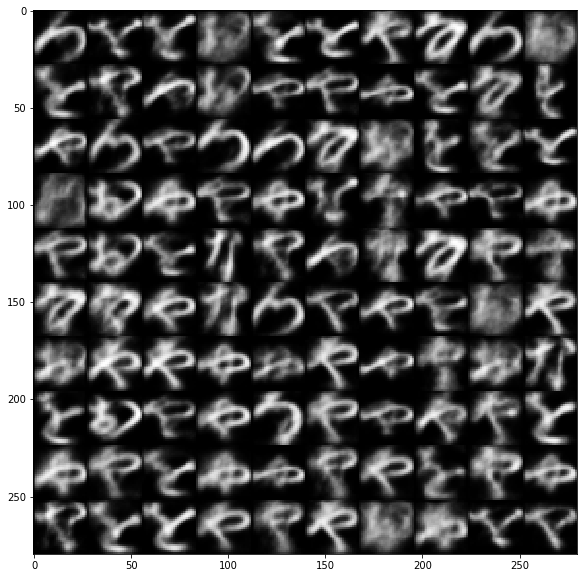

In [10]:
# Make a grid of images, sampling from the prior
n_rows = 10
batch = torch.cat([vae.sample() for _ in range(n_rows**2)])
plot_grid(batch, img_width, n_rows)

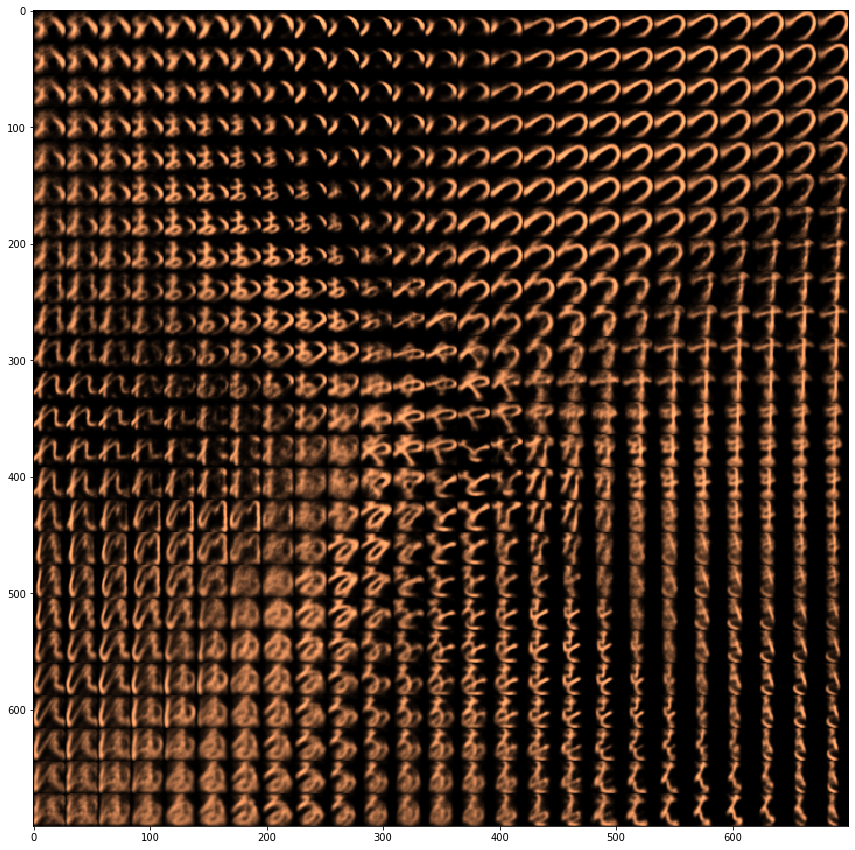

In [11]:
# Map points in the latent space to a grid
# This can only be done with a two dimensional latent space
if dim_z == 2:
    n_rows = 25
    z_scale = 5.5
    latents = torch.linspace(-z_scale, z_scale, n_rows)
    latent_batch = torch.FloatTensor(n_rows, n_rows, 2)
    for i in range(n_rows):
        for j in range(n_rows):
            latent_batch[i][j][0] = latents[i]
            latent_batch[i][j][1] = latents[j]
    latent_batch = latent_batch.view(-1, 2).to(device)
    out = vae.sample(z=latent_batch)
    plot_grid(out, img_width, n_rows, figsize=15, cmap="copper")